In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, roc_curve, precision_score, f1_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import sys
sys.path.append('F:\\MIFI-github\\MIFI_course_work_CML')
from modules.add_binar_classific_function import compare_models_binar_classific 

In [6]:
# Загрузка датасета
df = pd.read_csv('F:\\MIFI-github\\MIFI_course_work_CML\\Data\\dataset_CC50_median.csv')


C:\Users\Eve\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Eve\AppData\Roaming\Python\Python312\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\Eve\AppData\Roaming\Python\Python312\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
C:\Users\Eve\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



=== Без снижения размерности ===

LogisticRegression:
  Лучшие параметры: {'C': 0.1}
  Accuracy: 0.711
  Precision: 0.672
  Recall: 0.820
  F1: 0.739
  ROC AUC: 0.827

DecisionTree:
  Лучшие параметры: {'max_depth': 5}
  Accuracy: 0.657
  Precision: 0.626
  Recall: 0.770
  F1: 0.691
  ROC AUC: 0.708

RandomForest:
  Лучшие параметры: {'max_depth': None, 'n_estimators': 100}
  Accuracy: 0.716
  Precision: 0.690
  Recall: 0.780
  F1: 0.732
  ROC AUC: 0.844

CatBoost:
  Лучшие параметры: {'depth': 6, 'learning_rate': 0.01}
  Accuracy: 0.731
  Precision: 0.702
  Recall: 0.800
  F1: 0.748
  ROC AUC: 0.850

MLPClassifier:
  Лучшие параметры: {'hidden_layer_sizes': (100,), 'max_iter': 1000}
  Accuracy: 0.751
  Precision: 0.727
  Recall: 0.800
  F1: 0.762
  ROC AUC: 0.856

SVC:
  Лучшие параметры: {'C': 1, 'kernel': 'rbf'}
  Accuracy: 0.721
  Precision: 0.696
  Recall: 0.780
  F1: 0.736
  ROC AUC: 0.819

=== PCA ===

LogisticRegression:
  Лучшие параметры: {'C': 0.1}
  Accuracy: 0.677
  Preci

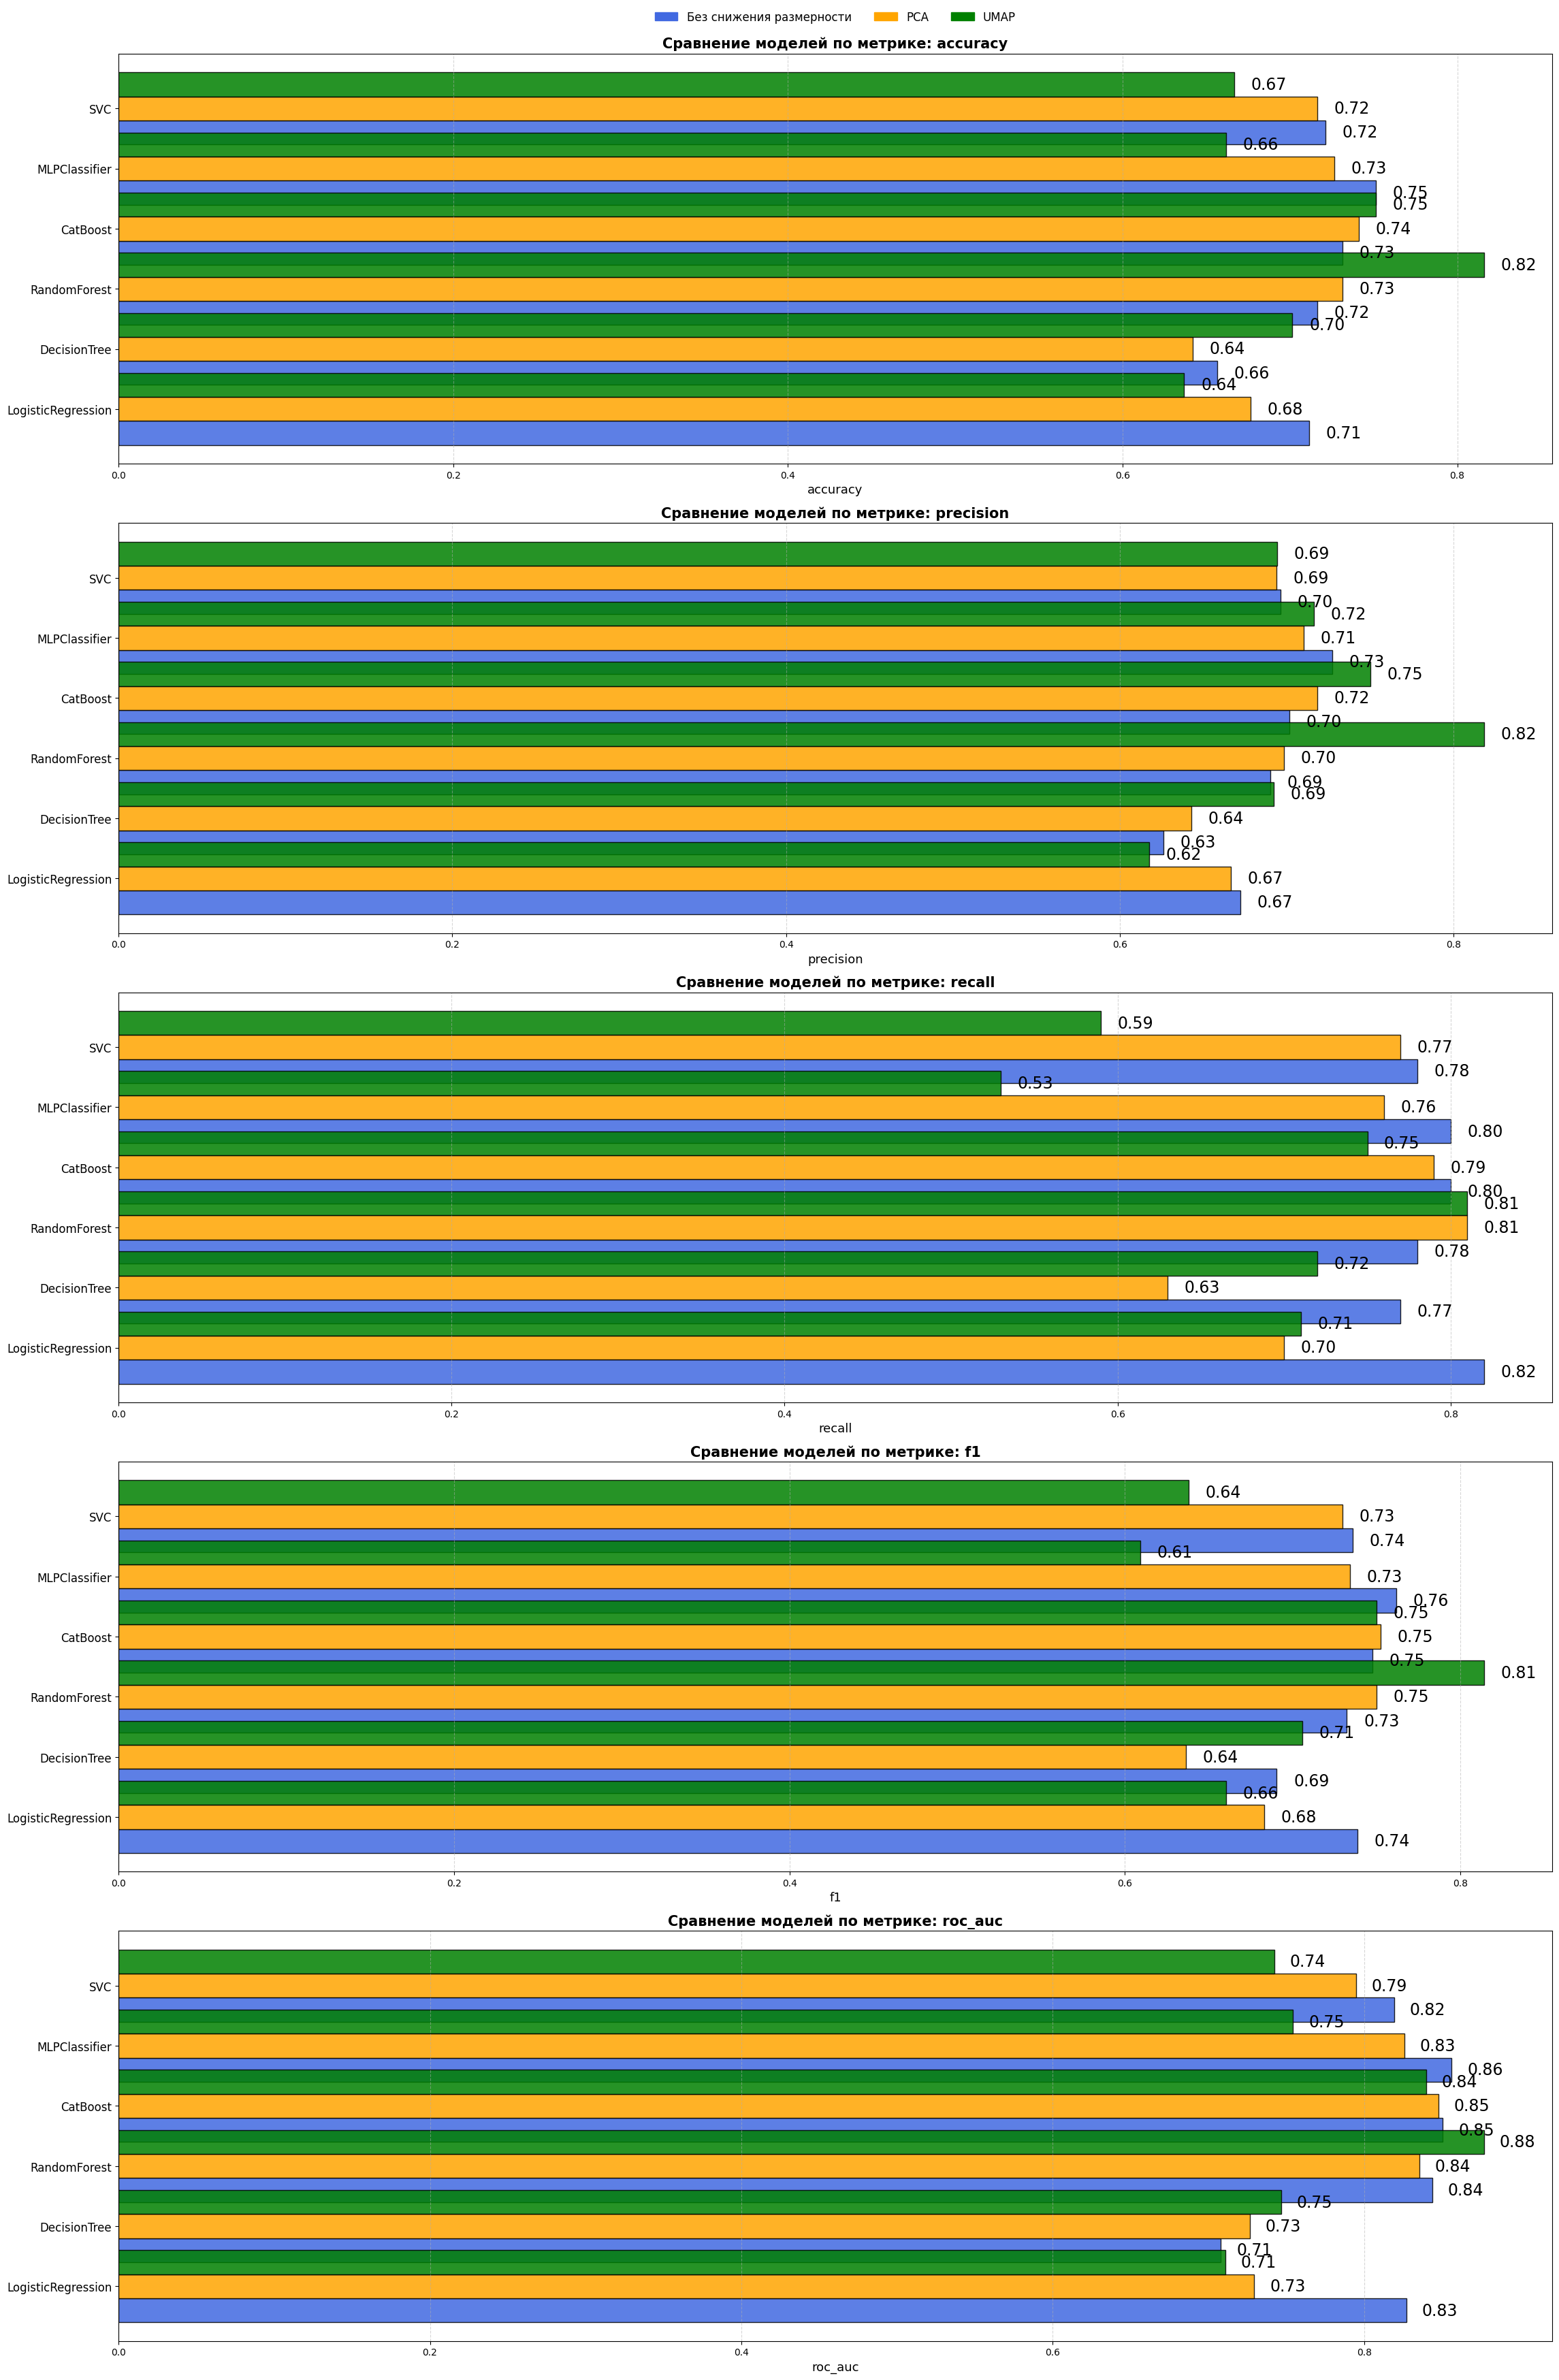

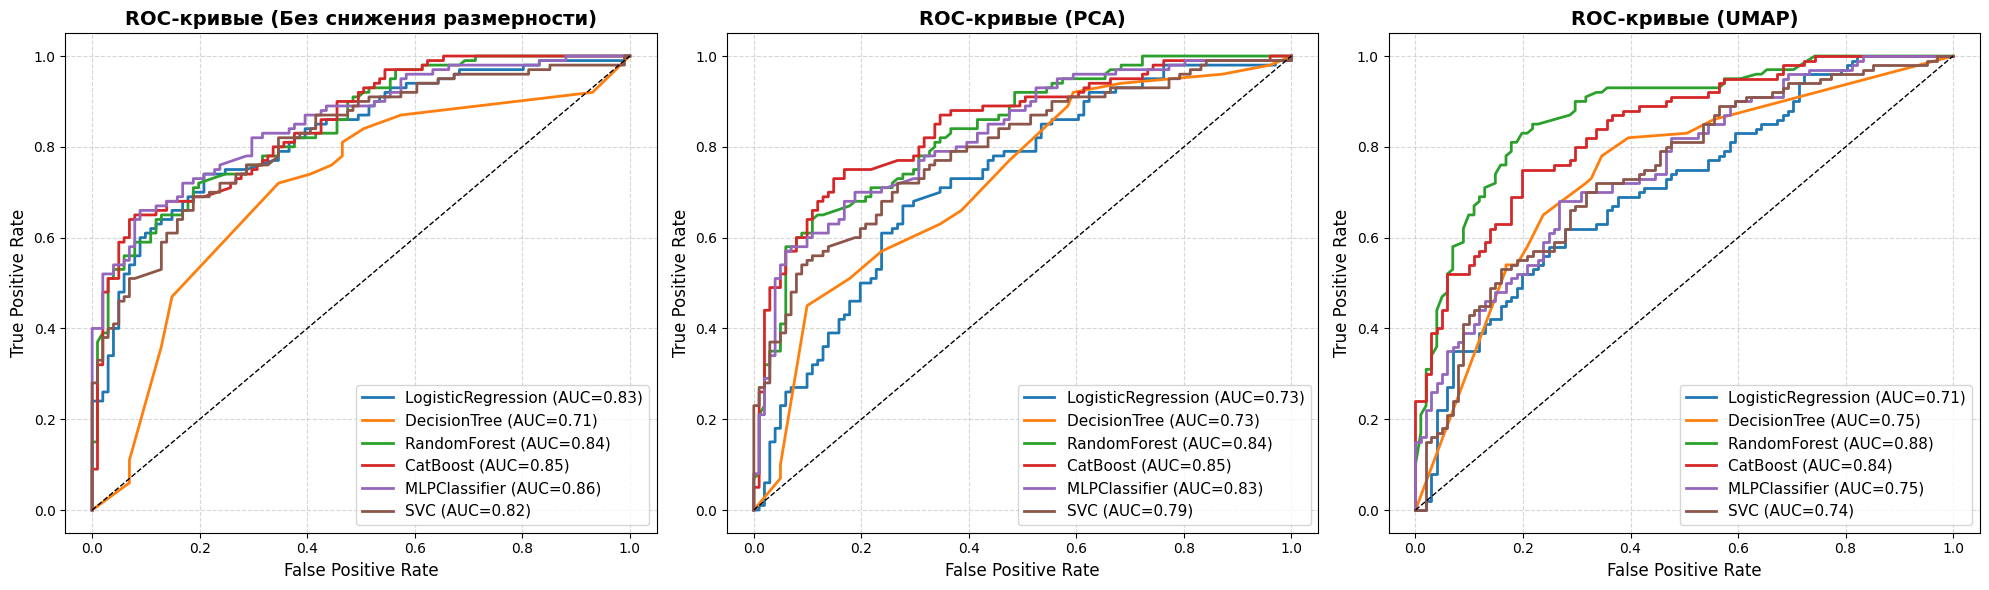

In [8]:

def compare_models_binar_classific(
    df, 
    target_col='High_CC50', 
    test_size=0.2, 
    random_state=42, 
    n_components=15,
    **kwargs
):
    # Подготовка данных
    features = df.drop(columns=[target_col])
    target = df[target_col]
    
    # Разделение данных (stratify добавлен для безопасности, но не влияет из-за random_state)
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, 
        test_size=test_size,
        random_state=random_state,
        stratify=target
    )
    
    # Предобработка: масштабирование и PCA
    scaler = StandardScaler()
    pca_transformer = PCA(n_components=n_components)
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    X_train_pca = pca_transformer.fit_transform(X_train_scaled)
    X_test_pca = pca_transformer.transform(X_test_scaled)
    
    # Модели для сравнения
    classifiers = {
        'Logistic Regression': LogisticRegression(
            random_state=random_state,
            max_iter=1000  # Добавлено для гарантированной сходимости
        ),
        'Random Forest': RandomForestClassifier(
            random_state=random_state,
            n_estimators=100
        ),
        'Support Vector Machine': SVC(
            random_state=random_state,
            probability=True  # Необходимо для ROC-AUC
        )
    }
    
    # Оценка моделей
    evaluation_results = {}
    for model_name, classifier in classifiers.items():
        classifier.fit(X_train_pca, y_train)
        y_pred = classifier.predict(X_test_pca)
        y_proba = classifier.predict_proba(X_test_pca)[:, 1]
        
        evaluation_results[model_name] = {
            'Accuracy': accuracy_score(y_test, y_pred),
            'F1 Score': f1_score(y_test, y_pred),
            'ROC AUC': roc_auc_score(y_test, y_proba),
            'Confusion Matrix': confusion_matrix(y_test, y_pred)
        }
    
    # Возвращаем DataFrame с результатами
    results_df = pd.DataFrame(evaluation_results).T
    results_df = results_df[['Accuracy', 'F1 Score', 'ROC AUC']]  # Упорядочиваем колонки
    return results_df